In [1]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "data/"

height_ratios_scaling: [1, 1, 1, 1]


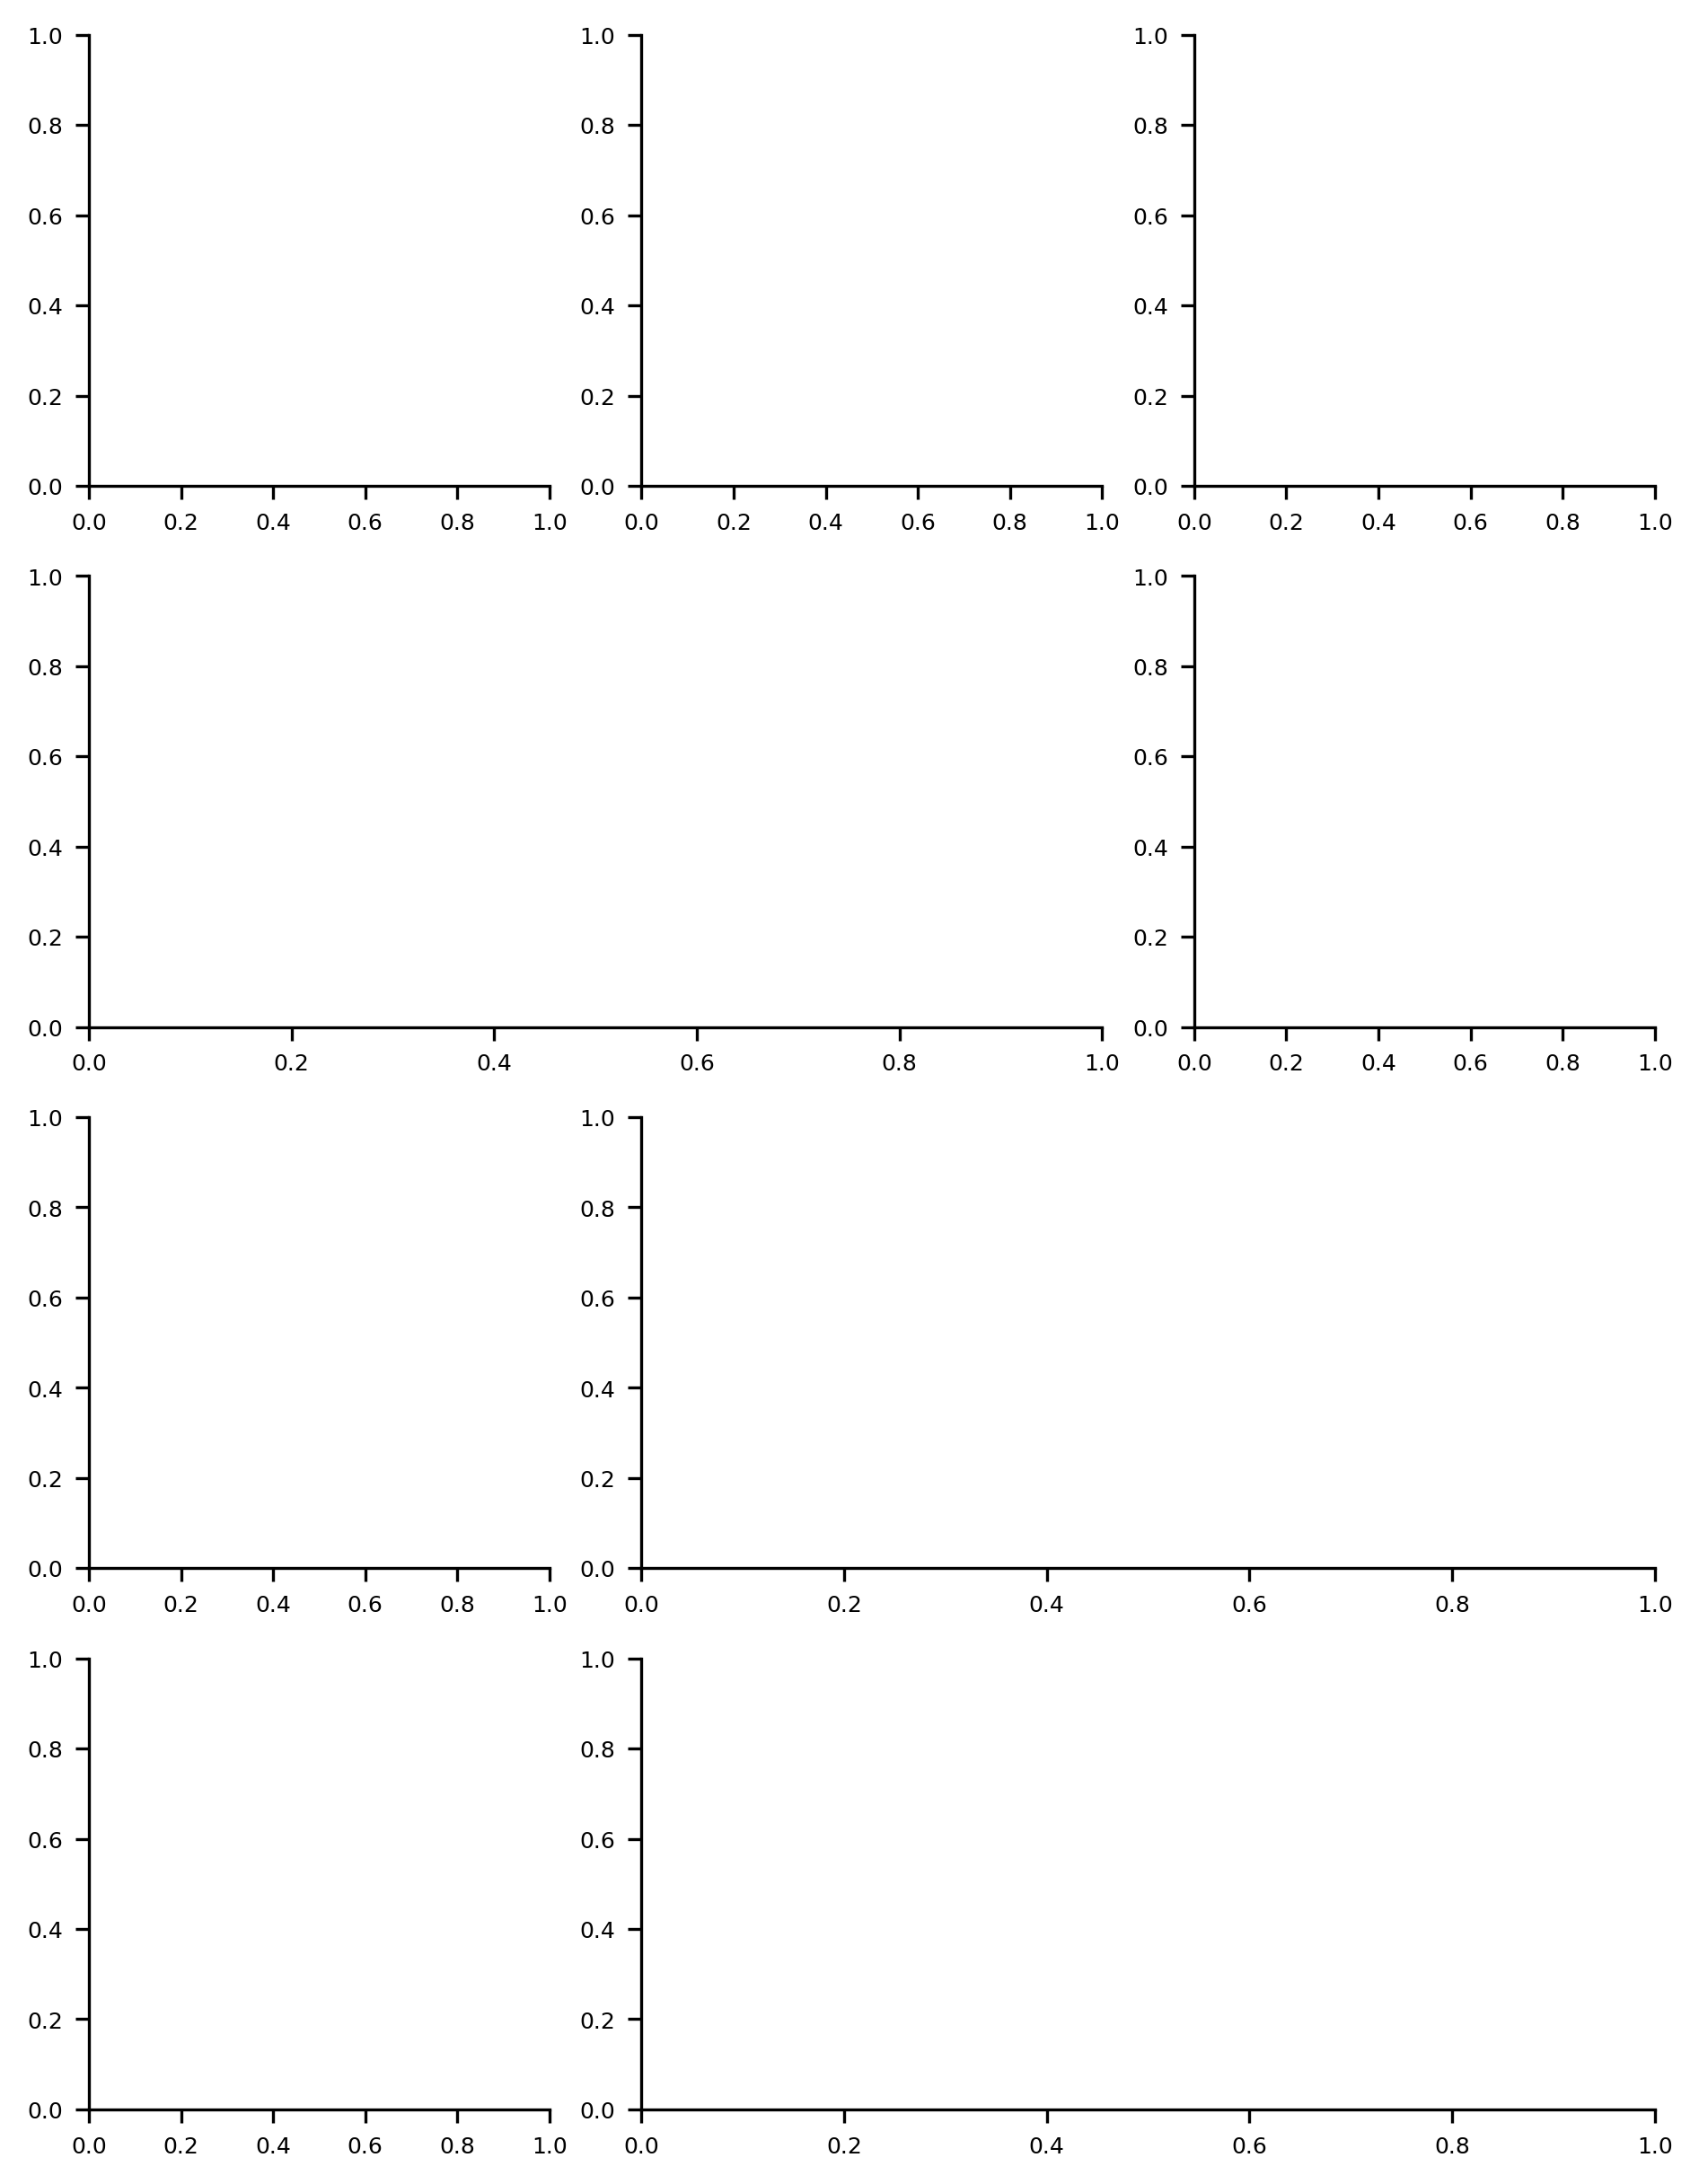

In [4]:
mosaic = [["A", "B", "C"], ["D", "D", "E"], ["F", "G", "G"], ["H", "I", "I"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [5]:
skin = pickle.load(open(os.path.join(DATA_FOLDER, "aorta_results.pkl"), "rb"))

In [6]:
def optimal_shift(p, p0, n_s=100):
    """
    Aligns two sequences defined on the unit circle, taking care of the periodicity
    and the flipping symmetry of the circle.
    It uses the median absolute deviation (MAD) as a measure of the distance between the two sequences.

    Parameters:
    p: phase array to adjust
    p0: phase array (reference)
    n_s: number of shifts to consider

    Returns:
    phi_aligned: the aligned phase array
    best_mad: the MAD of the best alignment
    """

    def circular_deviation2(x, y, period=2 * np.pi):
        """
        Function called by optimal_shift
        Inputs:
        x: phase array
        y: phase array
        period: period of the circular variable
        """
        x, y = x % period, y % period
        v1 = np.abs(x - y)
        v2 = (period - v1) % period

        return np.minimum(v1, v2)

    Nc = p.shape[0]
    shifts = np.linspace(0, 2 * np.pi, n_s)
    # creating a matrix of all possible shifts
    theta_cs = (p.reshape(Nc, 1) - shifts.reshape(1, n_s)) % (2 * np.pi)
    theta_cs_neg = (-p.reshape(Nc, 1) - shifts.reshape(1, n_s)) % (2 * np.pi)

    # for each shift, computing the circular deviation, using apply_along_axis
    delta_cs = circular_deviation2(p0[:, None], theta_cs)
    delta_cs_neg = circular_deviation2(p0[:, None], theta_cs_neg)

    # computing the median absolute deviation for all shifts
    v = np.median(delta_cs, axis=0)
    v_neg = np.median(delta_cs_neg, axis=0)
    # selecting the best shift
    best_shift_ind = np.argmin(v)
    best_shift_ind_neg = np.argmin(v_neg)
    mad, mad_neg = v[best_shift_ind], v_neg[best_shift_ind_neg]

    # selecting which direction is the best
    if mad < mad_neg:
        phi_aligned = theta_cs[:, best_shift_ind]
        best_mad = mad
    else:
        phi_aligned = theta_cs_neg[:, best_shift_ind_neg]
        best_mad = mad_neg

    return phi_aligned, best_mad


def get_MAD(adata, thetas):
    w = 2 * np.pi / 24
    true_phase = (adata.obs.zt.values % 24) * w
    if not isinstance(thetas, np.ndarray):
        thetas = thetas.detach().numpy()
    phi = thetas % (2 * np.pi)

    _, mad = optimal_shift(phi, true_phase)
    return mad / w


def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def get_genes_fractions(gene_names, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (adata[:, gene_names].layers[layer].toarray().T / library_size).T
    return gene_fractions


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    GT_phase=None,
    layer="total",
    hue=None,
    phase_label="Inferred",
    legend_title=None,
):
    try:
        axs = plot_helpers.replace_mosaic_cell_with_grid(
            fig, axs, label=position, nrows=1, ncols=len(gene_names)
        )
    except:
        pass
    if hue is not None:
        if isinstance(hue, str):
            # drop hue with less than 100 samples
            counts = adata.obs[hue].value_counts()
            valid_hues = counts[counts >= 100].index
            valid_indices = adata.obs[hue].values.isin(valid_hues)
            adata = adata[valid_indices]
            hue = adata.obs[hue].values
            inferred_phase = inferred_phase[valid_indices]
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        axs[position][i] = modify_xlabels(
            axs[position][i], add_endpoint=True, n_xticks=4
        )

        plotting.plot_smoothed_profiles(
            inferred_phase,
            np.log(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel="Inferred Phase",
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            label=(
                phase_label
                if (i == len(gene_names) - 1 and GT_phase is not None)
                else None
            ),
            legend=i == len(gene_names) - 1,
            hue=hue,
        )
        # set title in italic and bold
        axs[position][i].set_title(gene_name, fontstyle="italic", fontweight="bold")
        if i == len(gene_names) - 1 and legend_title is not None:
            axs[position][i].legend(title=legend_title)


def modify_xlabels(ax, n_xticks=8, add_endpoint=False):
    if add_endpoint:
        n_xticks += 1
    ticks = np.linspace(0, 2 * np.pi, n_xticks, endpoint=add_endpoint)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{int(tick / (2 * np.pi) * 24)}h" for tick in ticks])
    return ax


def shift_polar_plot(ax, inner_ring_size=0, n_xticks=8):

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    # Shift the radial axis upward so that plotting at r=0 actually
    # starts at r = inner_ring_size
    if inner_ring_size < 0:
        ax.set_rorigin(inner_ring_size)

    # Standard formatting
    ax.set_rlabel_position(0)
    ax = modify_xlabels(ax, n_xticks=n_xticks)
    # remove y ticks
    ax.set_yticks([])

    return ax

In [7]:
adata = skin["adata"]
phase_aligned = skin["phase_aligned"]

plot_helpers.make_polar(axs, "A")
shift_polar_plot(axs["A"], inner_ring_size=0)
ax = axs["A"]

sns.histplot(
    data=adata.obs,
    x=phase_aligned,
    hue="zt",
    element="step",
    palette="rainbow",
    ax=ax,
    fill=True,
    alpha=0.7,
    bins=30,
)
ax.set_title(f"Inferred Phases MAD: {get_MAD(adata, phase_aligned):.2f}h")
ax.set_ylabel("")

Text(0, 0.5, '')

In [8]:
cell_types = adata.obs["celltype"].unique().tolist()
for cell_type in cell_types:
    indices = adata.obs["celltype"] == cell_type
    print(get_MAD(adata[indices], phase_aligned[indices]), cell_type)

3.1160116432582727 endothelial
1.972026788236311 fibroblast
2.4110060894242764 macrophage
1.615604696101113 smc


In [9]:
z_space = skin["z"]
ax = axs["E"]
# drop celltypes with less than 100 samples
counts = adata.obs["celltype"].value_counts()
valid_hues = counts[counts >= 100].index
valid_indices = adata.obs["celltype"].values.isin(valid_hues)
plotting.plot_z_space_paper(
    z_space[valid_indices, 0],
    z_space[valid_indices, 1],
    ax=ax,
    alpha=0.5,
    hue=adata[valid_indices].obs["celltype"],
    legend=True,
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    legend_title="",
)

In [10]:
skin["df_rhythmic"]

,Nt5dc2,Krt8,Ckap2l,Cytip,Cdkn1c,Lrrc17,Adm,Grin3a,Smoc1,Ppbp,...,Hoxa7,Rerg,Grap2,Knl1,Fetub,Fcna,Tmem156,Gdf10,Ly6k,inferred_theta
0,-0.082700,-0.082235,0.084681,0.132646,-0.034256,-0.126521,-0.083223,0.154254,-0.006096,-0.119838,...,-0.009727,-0.231450,-0.270092,0.118415,-0.155919,-0.279087,0.404795,-0.040254,0.248775,-0.533112
1,0.070184,0.254808,-0.329400,-0.272127,0.016011,0.203352,0.081927,-0.198098,-0.118733,-0.628113,...,-0.005454,0.712448,-0.247727,0.042511,-0.190984,-0.044901,-0.759759,0.011605,0.408790,1.456681
2,-0.047731,0.038303,-0.070506,0.002596,-0.025825,-0.028532,-0.042796,0.057884,-0.060956,-0.407475,...,-0.011969,0.105621,-0.376977,0.134636,-0.239861,-0.291686,0.040690,-0.033690,0.430949,0.059106
3,-0.017850,0.169151,-0.241878,-0.132549,-0.020587,0.069648,-0.006549,-0.034580,-0.126483,-0.763107,...,-0.015948,0.471321,-0.540093,0.170019,-0.360250,-0.344855,-0.333091,-0.031475,0.679919,0.546598
4,-0.091430,-0.099141,0.105069,0.153741,-0.037291,-0.144144,-0.092510,0.173524,-0.001232,-0.100043,...,-0.010144,-0.278822,-0.277401,0.124558,-0.158005,-0.296022,0.466029,-0.043501,0.247477,-0.577318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20722,0.012373,-0.182084,0.257908,0.147790,0.018847,-0.081910,0.000581,0.047513,0.131094,0.784707,...,0.015858,-0.507531,0.541509,-0.167965,0.363009,0.337777,0.376742,0.029722,-0.688533,-2.542318
20723,-0.024986,0.170517,-0.246349,-0.128400,-0.024141,0.063119,-0.013214,-0.024341,-0.132676,-0.806827,...,-0.017414,0.474949,-0.585214,0.186779,-0.388492,-0.381826,-0.317196,-0.035980,0.729740,0.496053
20724,-0.084816,-0.284047,0.364830,0.308264,-0.021034,-0.233358,-0.097548,0.230725,0.127492,0.664856,...,0.004822,-0.794369,0.237808,-0.032914,0.189067,0.017893,0.864426,-0.016936,-0.413994,-1.609529
20725,-0.039014,-0.254558,0.340278,0.248645,-0.000929,-0.171615,-0.052437,0.151124,0.141620,0.794556,...,0.011398,-0.710962,0.428781,-0.110906,0.303476,0.196910,0.676355,0.007315,-0.605568,-2.068249


In [11]:
skin["fourier_coefficients"].shape

(2022, 2)

In [12]:
skin.keys()

dict_keys(['adata', 'phase_aligned', 'fourier_coefficients', 'lambda', 'df_z', 'df_rhythmic', 'df_mean', 'z', 'SMALL_CYCLING_GENE_SET', 'variable_genes', 'rhythmic_gene_indices'])

In [13]:
# df_phase_ptp = pd.DataFrame(
#     skin["fourier_coefficients"][skin["rhythmic_gene_indices"]],
#     index=skin["SMALL_CYCLING_GENE_SET"],
#     columns=["cos", "sin"],
# )
# df_phase_ptp["peak_to_peak"] = (
#     2 * np.sqrt(df_phase_ptp["cos"] ** 2 + df_phase_ptp["sin"] ** 2) / np.log(2)
# )
# df_phase_ptp["phase"] = np.arctan2(df_phase_ptp["cos"], df_phase_ptp["sin"])
df_rhythmic = (
    skin["df_rhythmic"][list(skin["SMALL_CYCLING_GENE_SET"])]
    / skin["lambda"]
    / np.log(2)
)
df_rhythmic["inferred_theta"] = skin["df_rhythmic"]["inferred_theta"]
df_phase_ptp = utils.get_ptp_phase(
    df_rhythmic,
    columns_not_gene=["inferred_theta"],
)

from CoPhaser import gene_sets


def plot_fourrier_coefficients(
    df_phase_ptp, phase_aligned, inferred_theta, axs, ax_label
):
    plot_helpers.make_polar(axs, ax_label)
    ax = axs[ax_label]
    shift_polar_plot(ax, inner_ring_size=0)
    best_shift = utils.get_best_shift_direction(inferred_theta, phase_aligned)
    df_phase_ptp["phase"] = utils.normalize_angles(
        best_shift["direction"] * df_phase_ptp["phase"] - best_shift["shift"]
    )
    ax.scatter(df_phase_ptp["phase"], df_phase_ptp["peak_to_peak"], s=5, color="blue")
    for name, row in df_phase_ptp.iterrows():
        if row["peak_to_peak"] < 1:
            continue
        if name not in gene_sets.SMALL_CIRCADIAN_GENE_SET:
            continue
        # plot the gene name in italic
        ax.text(
            row["phase"],
            row["peak_to_peak"],
            name,
            fontstyle="italic",
            fontsize=constants.SMALL_SIZE,
            ha="center",
        )
    ax.set_title("Fourier Coefficients")
    # add yticks
    ax.set_yticks([3, 6])
    ax.set_yticklabels([3, 6])


plot_fourrier_coefficients(
    df_phase_ptp, phase_aligned, adata.obs["inferred_theta"], axs, "C"
)

In [14]:
adata

AnnData object with n_obs × n_vars = 20727 × 32285
    obs: 'batch', 'sample_id', 'sex', 'misaligned', 'zt', 'percent_mito', 'lib_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_qc_pass', 'umi_qc_pass', 'doublet_qc_pass', 'doublet_score', 'qc_pass', 'cluster', 'subcluster', 'log_L', 'phase', 'celltype', 'inferred_theta', 'library_size', 'leiden', 'Bmal1_fraction'
    uns: 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: '2d_embedding', 'denoised_log_dispersion_hat', 'denoised_log_mean_hat', 'embedding', 'X_umap'
    layers: 'total'
    obsp: 'distances', 'connectivities'

In [15]:
adata.obs["celltype"] == "immune"

index
ACACTGACATTGCCTC-1      False
ACTTAGGGTAGACAGC-1      False
AGAGCAGTCTAACGCA-1      False
AGTCATGTCCCGTGAG-1      False
AGTCTCCTCTAGTTCT-1      False
                        ...  
TTTGTTGCATGAAAGT-1      False
TTTGTTGGTCACTAGT-1-1    False
TTTGTTGGTGGCTACC-1      False
TTTGTTGGTTGCCGCA-1      False
TTTGTTGTCCACTTTA-1-1    False
Name: celltype, Length: 20727, dtype: bool

In [16]:
plot_gene_profiles(
    gene_names=["Nr1d1", "Dbp", "Bmal1"],
    adata=adata,
    inferred_phase=phase_aligned,
    axs=axs,
    position="D",
    layer="total",
    phase_label="Inferred",
    legend_title="",
    hue="celltype",
)

In [17]:
adata.obs["celltype"]

index
ACACTGACATTGCCTC-1      endothelial
ACTTAGGGTAGACAGC-1      endothelial
AGAGCAGTCTAACGCA-1      endothelial
AGTCATGTCCCGTGAG-1      endothelial
AGTCTCCTCTAGTTCT-1      endothelial
                           ...     
TTTGTTGCATGAAAGT-1              smc
TTTGTTGGTCACTAGT-1-1            smc
TTTGTTGGTGGCTACC-1              smc
TTTGTTGGTTGCCGCA-1              smc
TTTGTTGTCCACTTTA-1-1            smc
Name: celltype, Length: 20727, dtype: category
Categories (4, object): ['endothelial', 'fibroblast', 'macrophage', 'smc']

In [18]:
adata.var_names.str.contains("Bmal1").sum()

1

In [19]:
adata.obs.groupby(["celltype", "zt"]).size()

/tmp/ipykernel_412392/239500459.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["celltype", "zt"]).size()


celltype     zt
endothelial  0       48
             6       38
             12      44
             18      59
fibroblast   0      461
             6      592
             12     478
             18     537
macrophage   0       49
             6       60
             12      50
             18      59
smc          0     3733
             6     4254
             12    4143
             18    6122
dtype: int64

In [20]:
ax = axs["B"]
# plot mad per cell type
res = {}
for cell_type in adata.obs["celltype"].unique():
    indices = adata.obs["celltype"] == cell_type
    mad = get_MAD(adata[indices], phase_aligned[indices])
    res[cell_type] = mad
res = pd.DataFrame.from_dict(res, orient="index", columns=["MAD"])
res = res.sort_values("MAD")
order = adata.obs["celltype"].unique().tolist()
# put a \n at the start of %2 indexes
for i, ct in enumerate(res.index):
    if i % 2 == 1:
        res.index.values[i] = "\n" + ct
# color cell types according to alphabetical order and tab10
colors = cm.get_cmap("tab10", 10)
cell_type_colors = {ct: colors(i) for i, ct in enumerate(sorted(res.index))}
sns.barplot(x=res.index, y="MAD", data=res, ax=ax, palette=cell_type_colors)
ax.set_ylabel("MAD (hours)")
ax.set_xlabel("Cell Type")
ax.set_title("MAD by Cell Type")

/tmp/ipykernel_412392/1346405459.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", 10)
/tmp/ipykernel_412392/1346405459.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=res.index, y="MAD", data=res, ax=ax, palette=cell_type_colors)


Text(0.5, 1.0, 'MAD by Cell Type')

In [23]:
for ct in adata.obs["celltype"].unique().tolist():
    indices = adata.obs["celltype"] == ct
    print(ct, get_MAD(adata[indices], phase_aligned[indices]))

endothelial 3.1160116432582727
fibroblast 1.972026788236311
macrophage 2.4110060894242764
smc 1.615604696101113


In [24]:
adata.obs[["batch", "zt"]].drop_duplicates()

,batch,zt
index,,
ACACTGACATTGCCTC-1,2,6
AAAGGTAGTAGCTGTT-1,3,0
AAGAACAAGTTATGGA-1,8,12
AAACCCACATGACGAG-1,11,18


In [25]:
skin["df_z"]["Rgs5"]

0       -3.736371
1       -0.253984
2       -3.610089
3       -4.162897
4       -3.913704
           ...   
20722    1.628877
20723   -0.504313
20724   -1.092282
20725   -1.551369
20726   -2.818303
Name: Rgs5, Length: 20727, dtype: float32

In [26]:
z_space = skin["z"]
ax = axs["H"]
# drop celltypes with less than 100 samples
counts = adata.obs["celltype"].value_counts()
rgs5_counts = skin["df_z"]["Rgs5"]
valid_indices = adata.obs["leiden"].values.isin(["0", "1", "2"])

plotting.plot_z_space_paper(
    z_space[valid_indices, 0],
    z_space[valid_indices, 1],
    ax=ax,
    alpha=0.5,
    size=2,
    hue=rgs5_counts[valid_indices],
    legend=True,
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    title="SMC z space",
)
ax.legend(title="Rgs5 Δμ")

In [27]:
# clock genes
cycling_genes = list(gene_sets.SMALL_CIRCADIAN_GENE_SET) + ["Hlf", "Nfil3"]
cycling_genes.remove("Arntl")
df_to_plot = skin["df_z"][cycling_genes].copy()
df_to_plot["leiden"] = adata.obs["celltype"].astype(str).values
# df_to_plot = df_to_plot[df_to_plot["leiden"].isin(["0", "1", "2"])]
df_to_plot = df_to_plot.groupby("leiden").mean()
df_to_plot = df_to_plot.T
# remove mean
df_to_plot = df_to_plot.sub(df_to_plot.mean(axis=1), axis=0)
# sort by variance
df_to_plot = df_to_plot.loc[df_to_plot.var(axis=1).sort_values(ascending=False).index]
# add \n to cell type labels for even indexes
for i, ct in enumerate(df_to_plot.columns):
    if i % 2 == 1:
        df_to_plot.columns.values[i] = "\n" + ct
sns.heatmap(
    df_to_plot,
    cmap="magma",
    cbar_kws={"label": "Mean Δμ"},
    yticklabels=True,
    xticklabels=True,
    vmin=-2.5,
    ax=axs["F"],
)
# rotate x labels
axs["F"].set_xticklabels(axs["F"].get_xticklabels(), rotation=0)
axs["F"].set_title("Predicted Δμ")

Text(0.5, 1.0, 'Predicted Δμ')

In [28]:
plot_gene_profiles(
    gene_names=["Nfil3", "Hlf", "Npas2"],
    adata=adata,
    inferred_phase=phase_aligned,
    axs=axs,
    position="G",
    layer="total",
    phase_label="Inferred",
    legend_title="",
    hue="celltype",
)

In [29]:
adata.obs.groupby(["celltype", "zt"]).size()

/tmp/ipykernel_412392/239500459.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["celltype", "zt"]).size()


celltype     zt
endothelial  0       48
             6       38
             12      44
             18      59
fibroblast   0      461
             6      592
             12     478
             18     537
macrophage   0       49
             6       60
             12      50
             18      59
smc          0     3733
             6     4254
             12    4143
             18    6122
dtype: int64

In [30]:
valid_indices = adata.obs["leiden"].values.isin(["0", "1", "2"])
hue = (
    adata[valid_indices]
    .obs["leiden"]
    .astype(str)
    .map({"0": "med", "1": "high", "2": "low"})
).values
plot_gene_profiles(
    gene_names=["Nfil3", "Per1", "Nampt"],
    adata=adata[valid_indices],
    inferred_phase=phase_aligned[valid_indices],
    axs=axs,
    position="I",
    layer="total",
    phase_label="Inferred",
    legend_title="Rgs5",
    hue=hue,
)

In [31]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)

Figure saved to: /home/maxine/Documents/paychere/CoPhaser/paper/figures/figure_4_circadian_python.svg


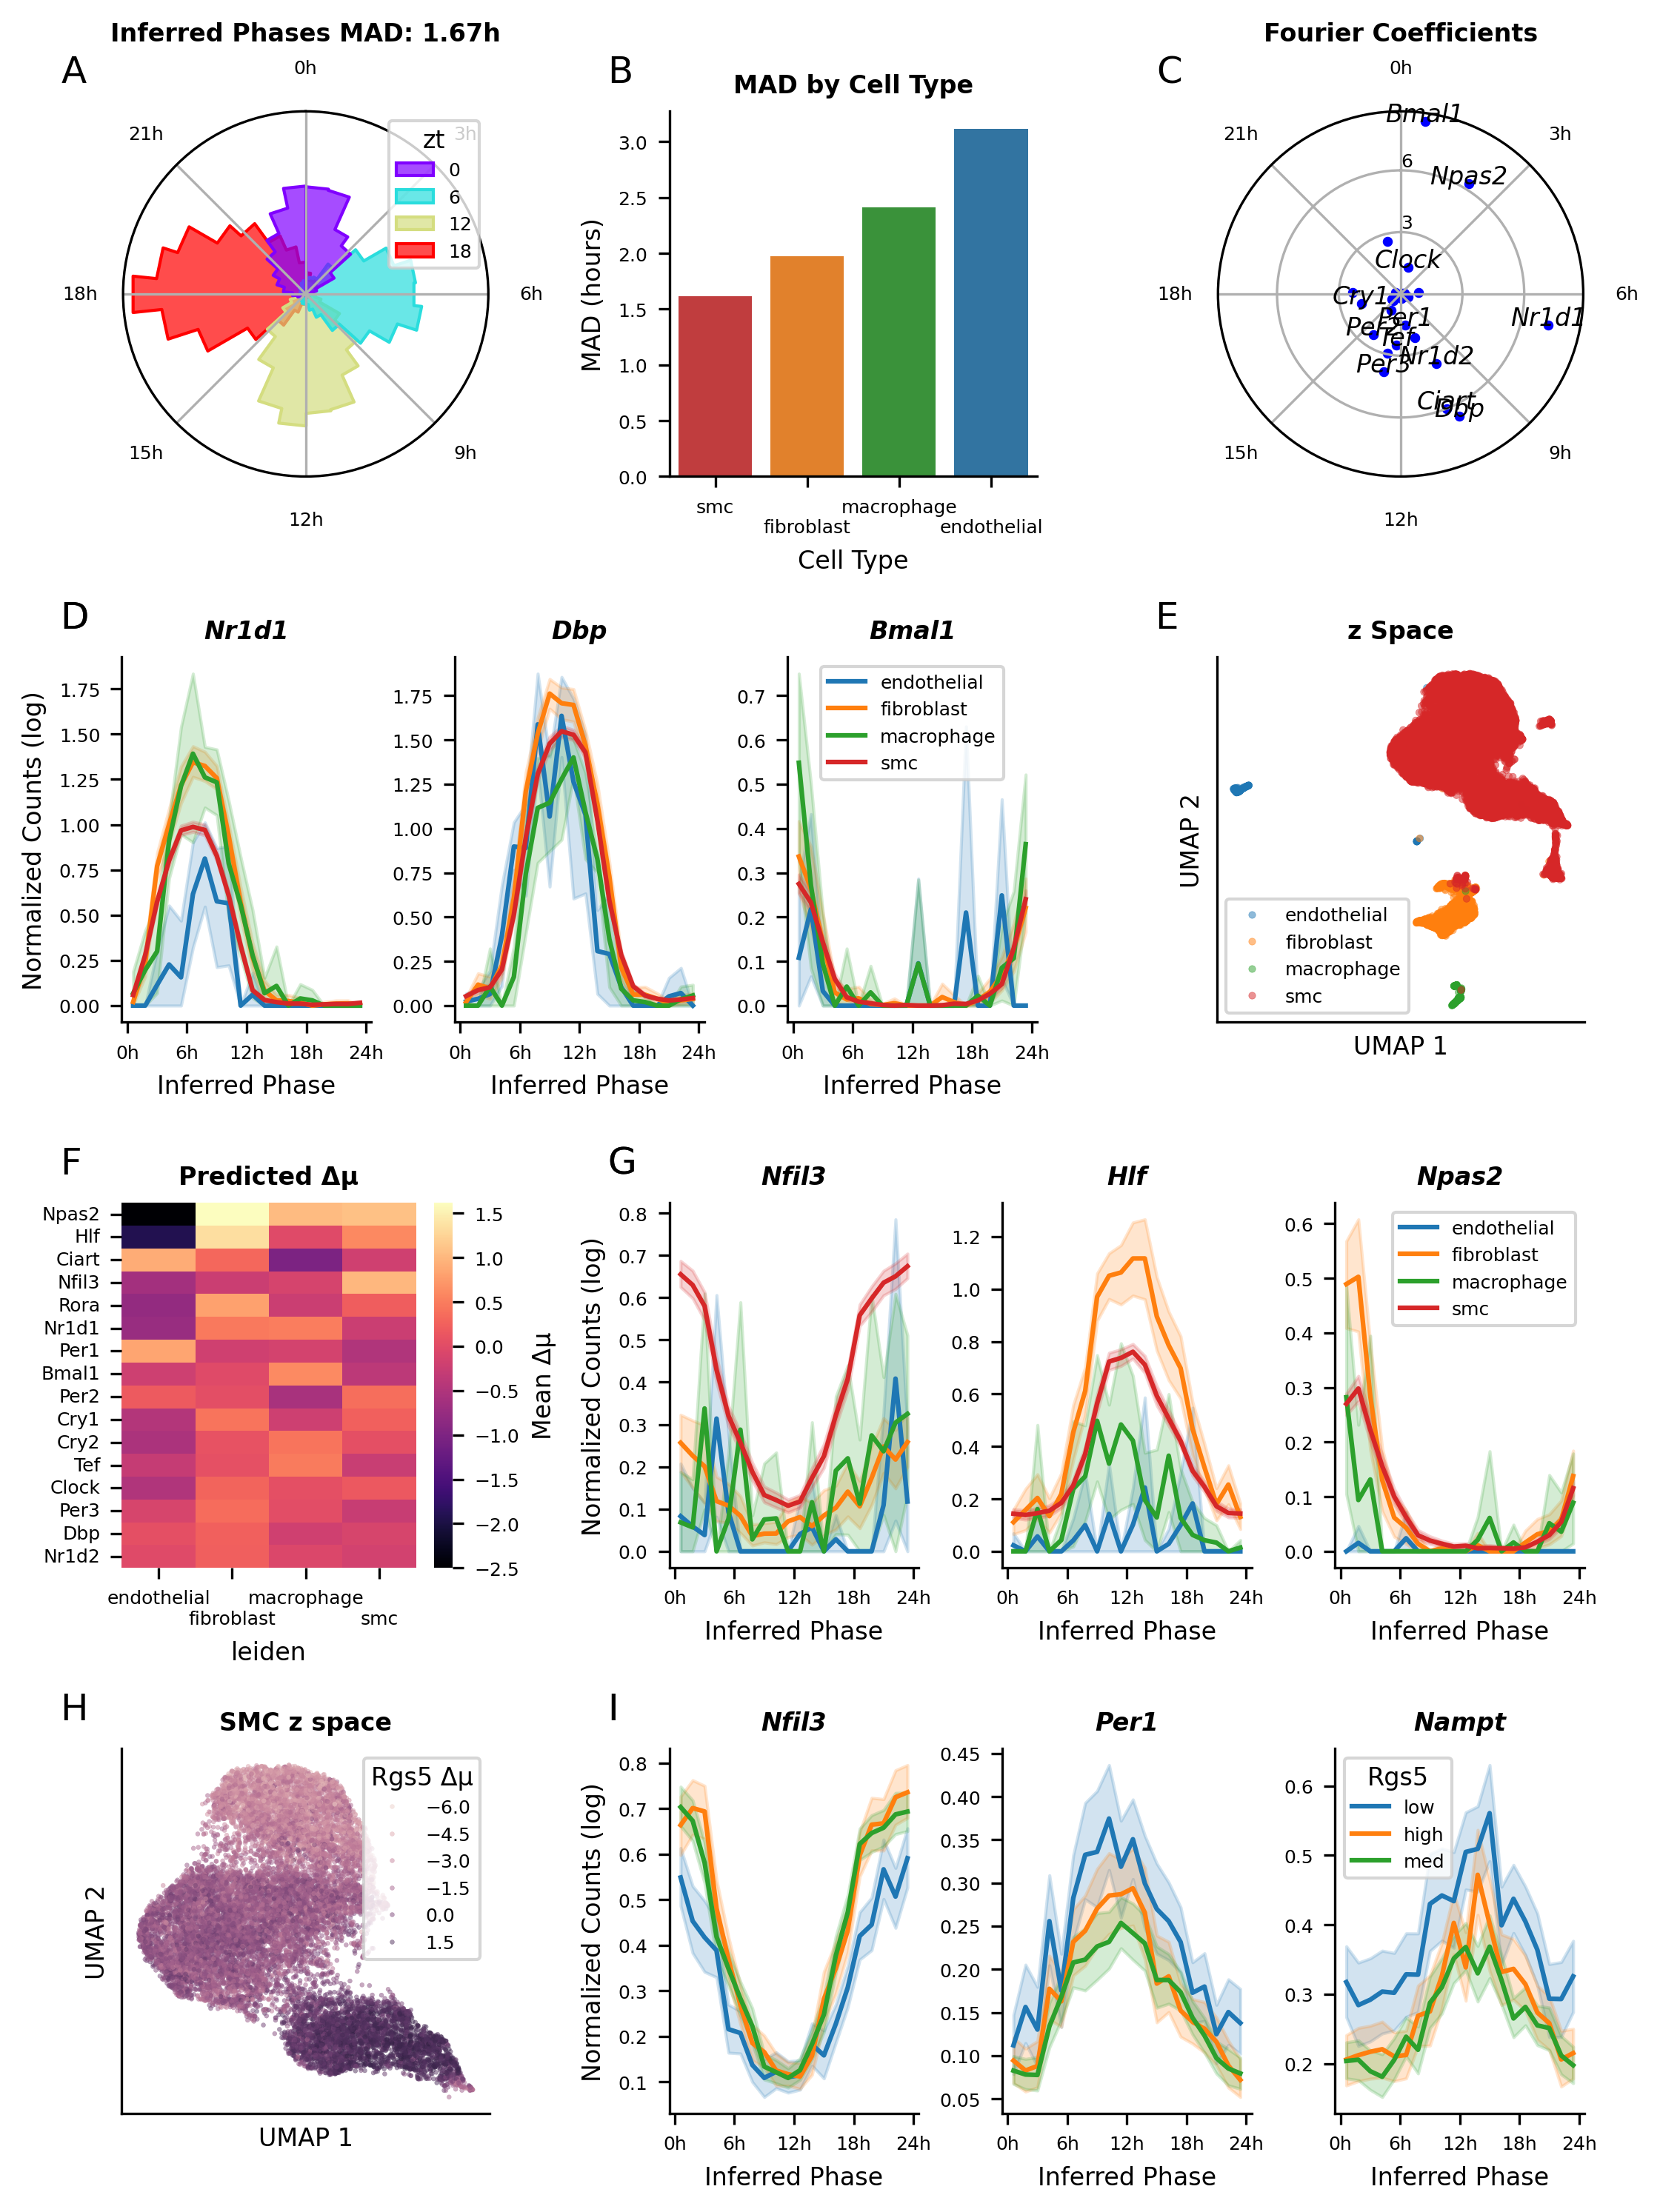

In [ ]:
plot_helpers.save_figure(fig, axs, "figure_5_circadian_python")